In [ ]:
#build_models.ipynb
#
#Copyright (c) 2019, Joe Hahn
#
#by Joe Hahn
#joe.hahn@oracle.com
#23 September 2018
#
#build models that predict time til next failure

In [1]:
#start time
import time as tm
clock_start = tm.time()

In [2]:
#import python & helper_fns used below
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)    #tell pandas to display all columns

In [3]:
#import plotting libraries
#use following line when in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

In [4]:
#read pdm input parameters
inputs_path = 'inputs_pdm.py'
exec(open(inputs_path).read())
print ('inputs_path = ', inputs_path)
print ('debug = ', debug)
print ('N_devices = ', N_devices)
print ('sensor_sigma = ', sensor_sigma)
print ('N_timesteps = ', N_timesteps)
print ('time_start = ', time_start)
print ('output_interval = ', output_interval)
print ('strategy = ', strategy)
print ('pdm_threshold_time = ', pdm_threshold_time)
print ('pdm_threshold_probability = ', pdm_threshold_probability)
print ('pdm_skip_time = ', pdm_skip_time)
print( 'N_technicians = ', N_technicians)
print ('repair_duration = ', repair_duration)
print ('maintenance_duration = ', maintenance_duration)
print ('rn_seed = ', rn_seed)
print ('issues = ', issues)

inputs_path =  inputs_pdm.py
debug =  True
N_devices =  700
sensor_sigma =  0.01
N_timesteps =  20000
time_start =  0
output_interval =  10
strategy =  pdm
pdm_threshold_time =  400
pdm_threshold_probability =  0.5
pdm_skip_time =  5
N_technicians =  70.0
repair_duration =  100
maintenance_duration =  25.0
rn_seed =  18
issues =  {'crud': {'ID': 0, 'coefficient': 0.1, 'fatal': False}, 'jammed_plunger': {'ID': 1, 'coefficient': 8e-05, 'fatal': True}, 'cracked_valve': {'ID': 2, 'coefficient': 1e-05, 'fatal': True}, 'broken_rods': {'ID': 3, 'coefficient': 2e-06, 'fatal': True}}


In [5]:
#get telemetry data, repairs data, and records=telemetry.join.repairs
time_bucket_size = 20
telemetry_file = './data/telemetry_rtf.csv.gz'
repairs_file = './data/repairs_rtf.csv.gz'
from helper_fns import * 
telemetry, repairs, records = prep_rtf_data(time_bucket_size, issues, telemetry_file, repairs_file)
print (records.dtypes)
print ('telemetry.shape = ', telemetry.shape)
print ('repairs.shape = ', repairs.shape)
print ('records.shape = ', records.shape)
records.head()

reading ./data/telemetry_rtf.csv.gz ...
pivoting telemetry...
reading ./data/repairs_rtf.csv.gz ...
merging telemetry and repairs...
issue_names =  ['jammed_plunger', 'cracked_valve', 'broken_rods']
computing time to next issue...
computing time since previous issue...
deviceID                       int64
time_bucket                    int64
time                           int64
load                         float64
pressure                     float64
temperature                  float64
production_rate              float64
technicianID                   int32
issue                         object
production_rate_fail         float64
temperature_fail             float64
pressure_fail                float64
load_fail                    float64
time_til_jammed_plunger       object
time_til_cracked_valve        object
time_til_broken_rods          object
time_since_jammed_plunger     object
time_since_cracked_valve      object
time_since_broken_rods        object
dtype: object
telemetry.sha

,deviceID,time_bucket,time,load,pressure,temperature,production_rate,technicianID,issue,production_rate_fail,temperature_fail,pressure_fail,load_fail,time_til_jammed_plunger,time_til_cracked_valve,time_til_broken_rods,time_since_jammed_plunger,time_since_cracked_valve,time_since_broken_rods
0,0,0,0,0.022973,0.000705,0.041496,0.994682,-1,none,NaN,NaN,NaN,NaN,1080,4960,14380,NaN,NaN,NaN
1,0,1,20,-0.001613,0.000950,0.105344,0.989583,-1,none,NaN,NaN,NaN,NaN,1060,4940,14360,NaN,NaN,NaN
2,0,2,40,-0.031615,-0.021926,0.109987,0.988177,-1,none,NaN,NaN,NaN,NaN,1040,4920,14340,NaN,NaN,NaN
3,0,3,60,-0.045914,0.006763,0.083823,0.990792,-1,none,NaN,NaN,NaN,NaN,1020,4900,14320,NaN,NaN,NaN
4,0,4,80,-0.062995,0.002378,0.047358,0.992087,-1,none,NaN,NaN,NaN,NaN,1000,4880,14300,NaN,NaN,NaN


In [7]:
#get fatal issues and their ID
print('issues = ', issues)
fatal_issues = [issue_name for issue_name, d in issues.items() if (d['fatal'] == True)]
fatal_issueIDs = [issues[fatal_issue]['ID'] for fatal_issue in fatal_issues]
print('fatal_issues = ', fatal_issues)
print('fatal_issueIDs = ', fatal_issueIDs)

issues =  {'crud': {'ID': 0, 'coefficient': 0.1, 'fatal': False}, 'jammed_plunger': {'ID': 1, 'coefficient': 8e-05, 'fatal': True}, 'cracked_valve': {'ID': 2, 'coefficient': 1e-05, 'fatal': True}, 'broken_rods': {'ID': 3, 'coefficient': 2e-06, 'fatal': True}}
fatal_issues =  ['jammed_plunger', 'cracked_valve', 'broken_rods']
fatal_issueIDs =  [1, 2, 3]


In [8]:
#list issues & their frequency
df = records
N_issues = df.groupby('issue')['time'].count().sort_values(ascending=False)
print(N_issues)

issue
none              689228
jammed_plunger      5681
cracked_valve       3149
broken_rods         1942
Name: time, dtype: int64


In [9]:
#select no-issue records
df = records
idx = (df.issue == 'none') & (df.production_rate > 0.1)
df = df[idx].copy()
records_none = df
print('records_none.shape = ', records_none.shape)
records_none.head()

records_none.shape =  (643878, 19)


,deviceID,time_bucket,time,load,pressure,temperature,production_rate,technicianID,issue,production_rate_fail,temperature_fail,pressure_fail,load_fail,time_til_jammed_plunger,time_til_cracked_valve,time_til_broken_rods,time_since_jammed_plunger,time_since_cracked_valve,time_since_broken_rods
0,0,0,0,0.022973,0.000705,0.041496,0.994682,-1,none,NaN,NaN,NaN,NaN,1080,4960,14380,NaN,NaN,NaN
1,0,1,20,-0.001613,0.000950,0.105344,0.989583,-1,none,NaN,NaN,NaN,NaN,1060,4940,14360,NaN,NaN,NaN
2,0,2,40,-0.031615,-0.021926,0.109987,0.988177,-1,none,NaN,NaN,NaN,NaN,1040,4920,14340,NaN,NaN,NaN
3,0,3,60,-0.045914,0.006763,0.083823,0.990792,-1,none,NaN,NaN,NaN,NaN,1020,4900,14320,NaN,NaN,NaN
4,0,4,80,-0.062995,0.002378,0.047358,0.992087,-1,none,NaN,NaN,NaN,NaN,1000,4880,14300,NaN,NaN,NaN


In [11]:
#flag records whose time_til_issue < pdm_threshold_time
df = records_none
cols = ['deviceID', 'time']
for issue in fatal_issues:
    y_col = issue + '_in_' + str(pdm_threshold_time)
    time_til_col = 'time_til_' + issue
    df[y_col] = 0
    idx = (df[time_til_col] <= pdm_threshold_time)
    df.loc[idx, y_col] = 1
    cols += [time_til_col, y_col]
records_y = df
print ('records_y.shape = ', records_y.shape)
records_y[cols][25:35]

records_y.shape =  (643878, 22)


,deviceID,time,time_til_jammed_plunger,jammed_plunger_in_400,time_til_cracked_valve,cracked_valve_in_400,time_til_broken_rods,broken_rods_in_400
25,0,500,580,0,4460,0,13880,0
26,0,520,560,0,4440,0,13860,0
27,0,540,540,0,4420,0,13840,0
28,0,560,520,0,4400,0,13820,0
29,0,580,500,0,4380,0,13800,0
30,0,600,480,0,4360,0,13780,0
31,0,620,460,0,4340,0,13760,0
32,0,640,440,0,4320,0,13740,0
33,0,660,420,0,4300,0,13720,0
34,0,680,400,1,4280,0,13700,0


In [12]:
#get x_cols and y_cols
x_cols = ['load', 'pressure', 'temperature', 'production_rate'] + ['time_since_' + issue for issue in fatal_issues]
y_cols = [issue + '_in_' + str(pdm_threshold_time) for issue in fatal_issues]
print ('x_cols = ', x_cols)
print ('y_cols = ', y_cols)

x_cols =  ['load', 'pressure', 'temperature', 'production_rate', 'time_since_jammed_plunger', 'time_since_cracked_valve', 'time_since_broken_rods']
y_cols =  ['jammed_plunger_in_400', 'cracked_valve_in_400', 'broken_rods_in_400']


In [14]:
#filter records containg nan in any x_col
df = records_y
cols = x_cols + y_cols
idx = df[cols].isna().any(axis=1)
df = df[~idx]
records_filtered = df
print ('records_filtered.shape = ', records_filtered.shape)

records_filtered.shape =  (407965, 22)


In [15]:
#generate xy dataframe containing x features + target variables y
xy = records_filtered
xy.head()

,deviceID,time_bucket,time,load,pressure,temperature,production_rate,technicianID,issue,production_rate_fail,temperature_fail,pressure_fail,load_fail,time_til_jammed_plunger,time_til_cracked_valve,time_til_broken_rods,time_since_jammed_plunger,time_since_cracked_valve,time_since_broken_rods,jammed_plunger_in_400,cracked_valve_in_400,broken_rods_in_400
725,0,725,14500,-0.011264,-0.018468,-0.025851,0.996391,-1,none,NaN,NaN,NaN,NaN,300,60,NaN,1660,7420,120,1,1,0
726,0,726,14520,-0.003052,-0.024859,-0.010011,0.996216,-1,none,NaN,NaN,NaN,NaN,280,40,NaN,1680,7440,140,1,1,0
727,0,727,14540,-0.055141,-0.029069,0.010330,0.992683,-1,none,NaN,NaN,NaN,NaN,260,20,NaN,1700,7460,160,1,1,0
734,0,734,14680,0.029097,-0.001148,-0.040036,0.995018,-1,none,NaN,NaN,NaN,NaN,120,1100,NaN,1840,120,300,1,0,0
735,0,735,14700,0.104055,0.017275,-0.055841,0.989233,-1,none,NaN,NaN,NaN,NaN,100,1080,NaN,1860,140,320,1,0,0


In [16]:
#random test-train split
test_size = 0.33
from sklearn.model_selection import train_test_split
xy_train, xy_test = train_test_split(xy, test_size=test_size)
xy_test = xy_test.copy()
print ('xy_train.shape = ', xy_train.shape)
print ('xy_test.shape = ', xy_test.shape)

xy_train.shape =  (273336, 22)
xy_test.shape =  (134629, 22)


In [17]:
#build a random forest classifier
n_estimators = 51
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_estimators, random_state=rn_seed)
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 51,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 18,
 'verbose': 0,
 'warm_start': False}

In [18]:
#train & save models...takes 20 minutes
make_models = True
df = xy_train
import pickle as pkl
#model_folder = '/u01/bdcsce/tmp/'
model_folder = './'
if (make_models):
    for y_col in y_cols:
        x_train = df[x_cols].values
        y_train = df[y_col].values
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=rn_seed)
        model.fit(x_train, y_train)
        #save model
        model_file = model_folder + y_col + '_model.pkl'
        with open(model_file, 'wb') as file:  
            pkl.dump(model, file)
        print ('   saving ' + model_file)

   saving ./jammed_plunger_in_400_model.pkl
   saving ./cracked_valve_in_400_model.pkl
   saving ./broken_rods_in_400_model.pkl


In [19]:
#restore models
models = {}
for y_col in y_cols:
    model_file = model_folder + y_col + '_model.pkl'
    with open(model_file, 'rb') as file:  
        models[y_col] = pkl.load(file)
models

{'jammed_plunger_in_400': RandomForestClassifier(n_estimators=51, random_state=18),
 'cracked_valve_in_400': RandomForestClassifier(n_estimators=51, random_state=18),
 'broken_rods_in_400': RandomForestClassifier(n_estimators=51, random_state=18)}

In [20]:
#compute predictions & probabilities for test sample
x_test = xy_test[x_cols]
cols = ['deviceID', 'time', 'issue']
for y_col in y_cols:
    model = models[y_col]
    y_col_pred = y_col + '_pred'
    xy_test[y_col_pred] = model.predict(x_test)
    class_prob = model.predict_proba(x_test)
    classes = model.classes_
    cols += [y_col, y_col_pred]
    for cls in classes:
        y_col_prob = y_col_pred + '_prob' + str(cls)
        xy_test[y_col_prob] = class_prob[:, cls]
        cols += [y_col_prob]
xy_test[cols].tail()

,deviceID,time,issue,jammed_plunger_in_400,jammed_plunger_in_400_pred,jammed_plunger_in_400_pred_prob0,jammed_plunger_in_400_pred_prob1,cracked_valve_in_400,cracked_valve_in_400_pred,cracked_valve_in_400_pred_prob0,cracked_valve_in_400_pred_prob1,broken_rods_in_400,broken_rods_in_400_pred,broken_rods_in_400_pred_prob0,broken_rods_in_400_pred_prob1
730,458,14600,none,0,0,0.882353,0.117647,0,0,0.980392,0.019608,0,0,0.941176,0.058824
631,122,12620,none,0,0,1.000000,0.000000,0,0,1.000000,0.000000,0,0,0.960784,0.039216
779,86,15580,none,0,0,0.980392,0.019608,0,0,0.705882,0.294118,0,0,0.960784,0.039216
452,130,9040,none,0,0,0.745098,0.254902,0,0,0.941176,0.058824,0,0,1.000000,0.000000
901,628,18020,none,0,0,0.843137,0.156863,0,0,1.000000,0.000000,1,0,0.784314,0.215686


In [21]:
#save xy_test as csv
xy_test.to_csv('data/xy_test.csv.gz', header=False, index=False, sep='|', compression='gzip')
xy_test.dtypes

deviceID                              int64
time_bucket                           int64
time                                  int64
load                                float64
pressure                            float64
temperature                         float64
production_rate                     float64
technicianID                          int32
issue                                object
production_rate_fail                float64
temperature_fail                    float64
pressure_fail                       float64
load_fail                           float64
time_til_jammed_plunger              object
time_til_cracked_valve               object
time_til_broken_rods                 object
time_since_jammed_plunger            object
time_since_cracked_valve             object
time_since_broken_rods               object
jammed_plunger_in_400                 int64
cracked_valve_in_400                  int64
broken_rods_in_400                    int64
jammed_plunger_in_400_pred      

In [22]:
#compute issue-wise true & false positive fraction vs prediction probability
df = xy_test
false_positive_fraction = pd.DataFrame()
true_positive_fraction = pd.DataFrame()
for y_col in y_cols:
    y_col_pred = y_col + '_pred'
    df1 = df[df[y_col_pred] == 1].copy()
    y_col_prob1 = y_col_pred + '_prob1'
    probability = np.sort(df1[y_col_prob1].unique())
    false_pos_frac = np.zeros_like(probability)
    true_pos_frac = np.zeros_like(probability)
    for idx in range(len(probability)):
        prob = probability[idx]
        prob_min = prob - 0.001
        jdx = (df1[y_col_prob1] > prob_min)
        dfp = df1[jdx]
        false_positive = dfp[dfp[y_col] == 0]
        N_false_positive = len(false_positive)
        #if (N_false_positive < 1):
        #    N_false_positive += 1*0
        true_positive = dfp[dfp[y_col] == 1]
        N_true_positive = len(true_positive)
        N_positive = N_true_positive + N_false_positive
        false_pos_frac[idx] = N_false_positive*1.0/N_positive
        true_pos_frac[idx] = N_true_positive*1.0/N_positive
    false_positive_fraction[y_col] = pd.Series(data=false_pos_frac, index=probability)
    true_positive_fraction[y_col] = pd.Series(data=true_pos_frac, index=probability)
false_positive_fraction.index.name = 'probability'
true_positive_fraction.index.name = 'probability'

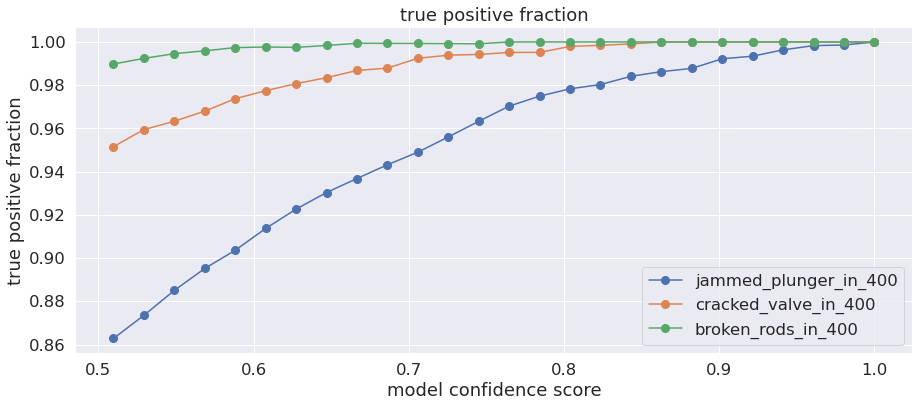

In [23]:
#plot true positive fraction vs prediction probability
df = true_positive_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('true positive fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('true positive fraction')
#p = ax.set_yscale('log')
#p = ax.set_ylim(0.0009, 1.1)
p = ax.legend()

In [24]:
df.tail()

,jammed_plunger_in_400,cracked_valve_in_400,broken_rods_in_400
probability,,,
0.921569,0.993418,1.0,1.0
0.941176,0.996355,1.0,1.0
0.960784,0.998304,1.0,1.0
0.980392,0.998590,1.0,1.0
1.000000,1.000000,1.0,1.0


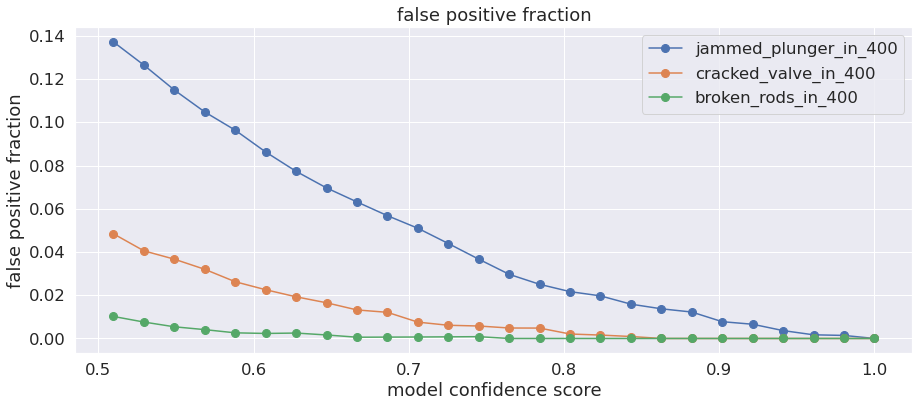

In [25]:
#plot false positive fraction vs prediction probability, for each issue
df = false_positive_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('false positive fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('false positive fraction')
p = ax.legend()

In [26]:
df.tail()

,jammed_plunger_in_400,cracked_valve_in_400,broken_rods_in_400
probability,,,
0.921569,0.006582,0.0,0.0
0.941176,0.003645,0.0,0.0
0.960784,0.001696,0.0,0.0
0.980392,0.001410,0.0,0.0
1.000000,0.000000,0.0,0.0


In [27]:
#compute overall true & false positive fraction vs prediction probability
df = xy_test
small = 0.001
true_positive_fraction = np.zeros_like(probability)
false_positive_fraction = np.zeros_like(probability)
for idx in range(len(probability)):
    prob = probability[idx]
    jdx = ((df.cracked_valve_in_400_pred == 1) & (df.cracked_valve_in_400_pred_prob1 > prob - small)) | \
          ((df.broken_rods_in_400_pred   == 1) & (df.broken_rods_in_400_pred_prob1   > prob - small)) | \
          ((df.jammed_plunger_in_400_pred  == 1) & (df.jammed_plunger_in_400_pred_prob1  > prob - small))
    df1 = df[jdx]
    N_true = len(df1)
    jdx = (df1.cracked_valve_in_400 == 1) | (df1.broken_rods_in_400 == 1) | (df1.jammed_plunger_in_400 == 1)
    N_true_positive = len(df1[jdx])
    jdx = (df1.cracked_valve_in_400 == 0) & (df1.broken_rods_in_400 == 0) & (df1.jammed_plunger_in_400 == 0)
    N_false_positive = len(df1[jdx])
    true_positive_fraction[idx] = N_true_positive*1.0/N_true
    false_positive_fraction[idx] = N_false_positive*1.0/N_true
data={'true_positive_fraction':true_positive_fraction, 'false_positive_fraction':false_positive_fraction}
TF_fraction = pd.DataFrame(data=data, index=probability)
TF_fraction.index.name = 'probability'
TF_fraction.tail()

,true_positive_fraction,false_positive_fraction
probability,,
0.921569,0.995784,0.004216
0.941176,0.997681,0.002319
0.960784,0.998695,0.001305
0.980392,0.998901,0.001099
1.000000,1.000000,0.000000


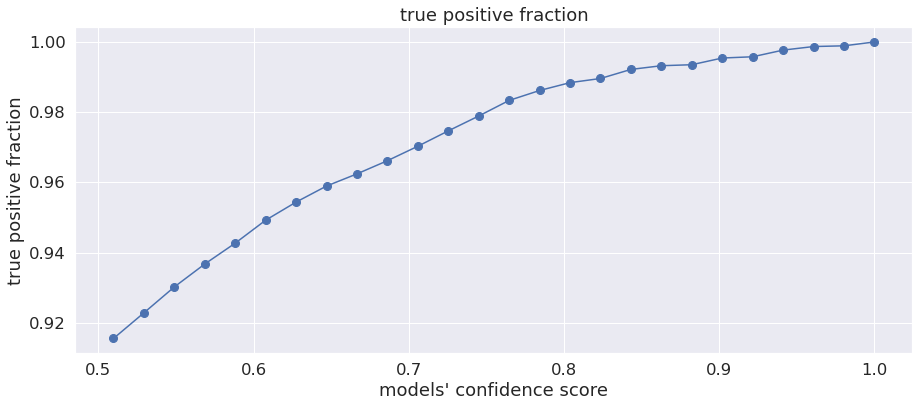

In [28]:
#plot overall true & false positive fraction vs prediction probability
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['true_positive_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('true positive fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('true positive fraction')

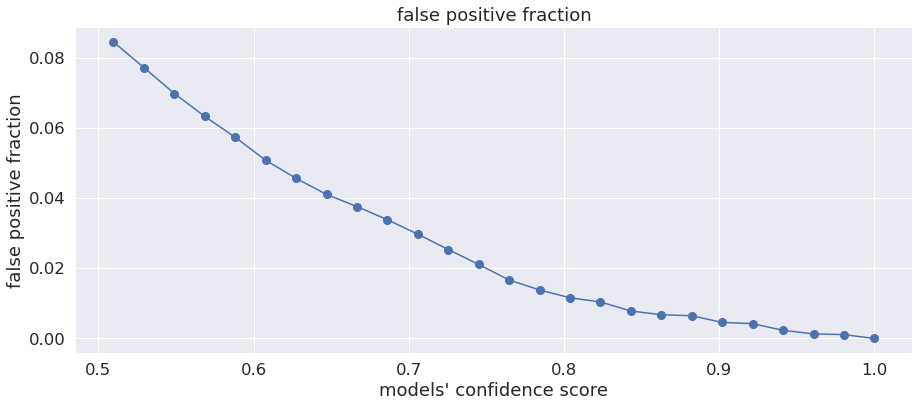

In [29]:
#plot overall false positive fraction vs prediction probability
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['false_positive_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('false positive fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('false positive fraction')
plt.savefig('figs/false_positives.png')

In [30]:
#compute issue-wise true & false negative fraction vs prediction probability
df = xy_test
false_negative_fraction = pd.DataFrame()
true_negative_fraction = pd.DataFrame()
for y_col in y_cols:
    y_col_pred = y_col + '_pred'
    df0 = df[df[y_col_pred] == 0].copy()
    y_col_prob0 = y_col_pred + '_prob0'
    probability = np.sort(df0[y_col_prob0].unique())
    false_neg_frac = np.zeros_like(probability)
    true_neg_frac = np.zeros_like(probability)
    for idx in range(len(probability)):
        prob = probability[idx]
        prob_min = prob - 0.001
        jdx = (df0[y_col_prob0] > prob_min)
        dfn = df0[jdx]
        false_negative = dfn[dfn[y_col] == 1]
        N_false_negative = len(false_negative)
        true_negative = dfn[dfn[y_col] == 0]
        N_true_negative = len(true_negative)
        N_negative = N_true_negative + N_false_negative
        false_neg_frac[idx] = N_false_negative*1.0/N_negative
        true_neg_frac[idx] = N_true_negative*1.0/N_negative
    false_negative_fraction[y_col] = pd.Series(data=false_neg_frac, index=probability)
    true_negative_fraction[y_col] = pd.Series(data=true_neg_frac, index=probability)
false_negative_fraction.index.name = 'probability'
true_negative_fraction.index.name = 'probability'

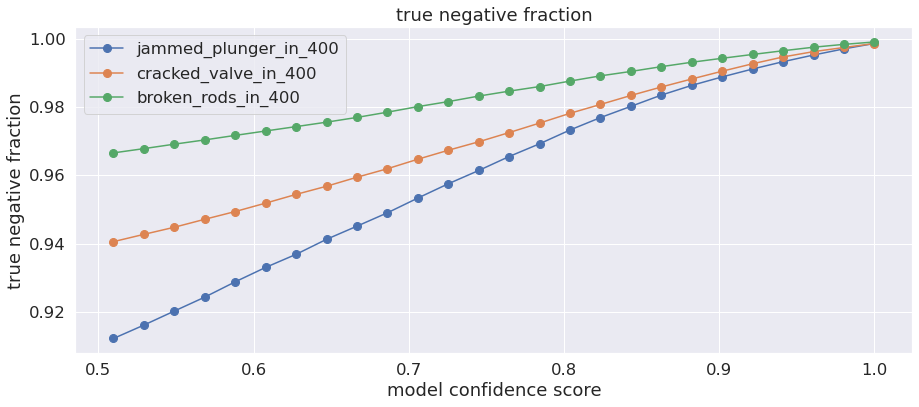

In [31]:
#plot true negative fraction vs prediction probability
df = true_negative_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('true negative fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('true negative fraction')
p = ax.legend()

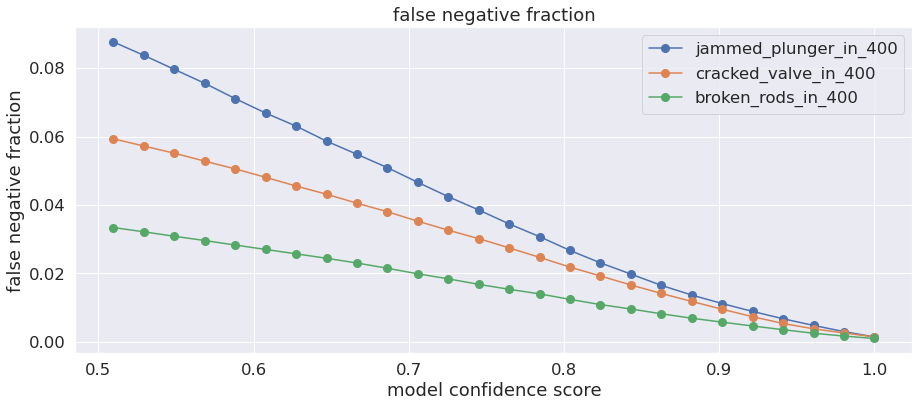

In [32]:
#plot false negative fraction vs prediction probability
df = false_negative_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('false negative fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('false negative fraction')
p = ax.legend()

In [33]:
#compute overall true & false negative fraction vs prediction probability
df = xy_test
small = 0.001
true_negative_fraction = np.zeros_like(probability)
false_negative_fraction = np.zeros_like(probability)
for idx in range(len(probability)):
    prob = probability[idx]
    jdx = ((df.cracked_valve_in_400_pred == 0) & (df.cracked_valve_in_400_pred_prob0 > prob - small)) & \
          ((df.broken_rods_in_400_pred   == 0) & (df.broken_rods_in_400_pred_prob0   > prob - small)) & \
          ((df.jammed_plunger_in_400_pred  == 0) & (df.jammed_plunger_in_400_pred_prob0  > prob - small))
    df0 = df[jdx]
    N_negative = len(df0)
    jdx = (df0.cracked_valve_in_400 == 0) & (df0.broken_rods_in_400 == 0) & (df0.jammed_plunger_in_400 == 0)
    N_true_negative = len(df0[jdx])
    jdx = (df0.cracked_valve_in_400 == 1) | (df0.broken_rods_in_400 == 1) | (df0.jammed_plunger_in_400 == 1)
    N_false_negative = len(df0[jdx])
    true_negative_fraction[idx] = N_true_negative*1.0/N_negative
    false_negative_fraction[idx] = N_false_negative*1.0/N_negative
data={'true_negative_fraction':true_negative_fraction, 'false_negative_fraction':false_negative_fraction}
TF_fraction = pd.DataFrame(data=data, index=probability)
TF_fraction.index.name = 'probability'
TF_fraction.tail()

,true_negative_fraction,false_negative_fraction
probability,,
0.921569,0.979694,0.020306
0.941176,0.986237,0.013763
0.960784,0.990754,0.009246
0.980392,0.995469,0.004531
1.000000,0.997638,0.002362


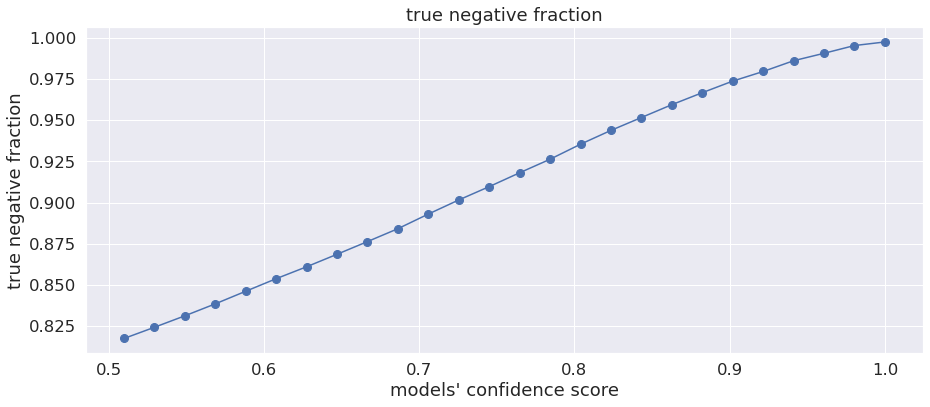

In [34]:
#plot overall true negative fraction vs prediction probability
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['true_negative_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('true negative fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('true negative fraction')

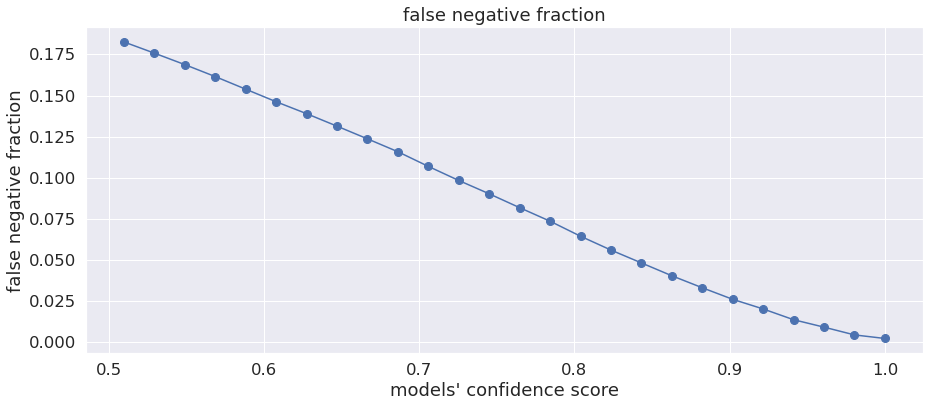

In [35]:
#plot overall false negative fraction vs prediction probability...this plot looks funny, is it correct?
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['false_negative_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('false negative fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('false negative fraction')
plt.savefig('figs/false_negatives.png')

In [ ]:
#done
print 'execution time (min) = ', (tm.time() - clock_start)/60.0